In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
from mmcv.image import imread
from mmdet.core import get_predicates, get_classes
import copy
import random
import cv2
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps
from PIL import Image
from factories.vgkr_v2.config_v2 import *
from factories.utils.tools import make_alias_dict
import mmcv
import numpy as np
from collections import defaultdict
import pandas as pd
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
from pandas import Series, DataFrame
import h5py
import os.path as osp
import os
from collections import Counter, defaultdict
import nltk
from nltk.corpus import wordnet as wn
from itertools import chain
colorlist = [(random.randint(0, 230), random.randint(0, 230), random.randint(0, 230)) for i in range(10000)]

In [2]:
meta_infos = pd.read_csv(meta_form_file, low_memory=False)
cap_sgentities = mmcv.load(cap_sgentities_vgcoco_file)

In [8]:
cleanse_objects = mmcv.load(cleanse_objects_file)  # 108,073
cleanse_rels = mmcv.load(cleanse_rels_file)   # 108,073

In [3]:
def draw_capentities(struct, obj_anots):
    pylab.rcParams['figure.figsize'] = 50, 25
    plt.figure()
    img = mmcv.imread(osp.join(IMAGE_ROOT_DIR, struct['path']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgh, imgw = img.shape[:2]
    ax = plt.subplot(2, 3, 1)
    sgs = struct['sg']
    for paint_idx, sg in enumerate(sgs):
        if sg['entities'] is not None: 
            ax = plt.subplot(2, 3, paint_idx+1)
            dets = sg['entities']['detections']
            for name, bbox_infos in dets.items():
                for i, det in enumerate(bbox_infos):
                    box_id, bbox = det[0], det[1]
                    bbox[2] = min(bbox[2], imgw-1)
                    bbox[3] = min(bbox[3], imgh-1)
                    left_top = (bbox[0], bbox[1])
                    color = tuple([t / 255. for t in colorlist[i]])
                    ax.add_patch(plt.Rectangle(left_top, bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor=color, linewidth=7.5, alpha=0.5))
                    ax.text(bbox[0], bbox[1] + 2, name, bbox=dict(facecolor=color, alpha=0.5), fontsize=30, color='black')
            ax.imshow(img)
            plt.xticks([])
            plt.yticks([])

    ax = plt.subplot(2, 3, 6)
    for i, obj in enumerate(obj_anots['objects']):
        x, y, w, h, name = max(obj['x']-1, 0), max(obj['y']-1, 0), obj['w'], obj['h'], obj['names'][0]
        color = tuple([t / 255. for t in colorlist[i]])
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=7.5, alpha=0.5))
        ax.text(x, y + 2, name, bbox=dict(facecolor=color, alpha=0.5), fontsize=30, color='black')
    ax.imshow(img)

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
        

In [16]:
def extractInfo(struct, obj_annots, rel_annots, imgh, imgw):
    # 1. Reorginize the caption-entities infos. 
    sgs = struct['sg']
    nodes, edges, captions, all_bboxes, all_names, all_det_seqs, all_noun_chunks = [], [], [], [], [], [], []
    for idx, sg in enumerate(sgs):
        if sg['entities'] is not None: 
            dets = sg['entities']['detections']
            bboxes, names = [], []
            for name, bbox_infos in dets.items():
                for i, det in enumerate(bbox_infos):
                    box_id, bbox = det[0], det[1]
                    bbox[2] = min(bbox[2], imgw-1)
                    bbox[3] = min(bbox[3], imgh-1)
                    bboxes.append(bbox)
                    names.append(name)
            all_bboxes.append(np.array(bboxes))
            all_names.append(names)
            all_det_seqs.append(sg['entities']['det_sequences'])
            all_noun_chunks.append(sg['entities']['noun_chunks'])
        else:
            all_bboxes.append(None)
            all_names.append(None)
            all_det_seqs.append(None)
            all_noun_chunks.append(None)
        nodes.append(sg['node'])
        edges.append(sg['edge'])
        captions.append(sg['caption'])
    infoFromCaps = DataFrame({"nodes": nodes, "edges": edges, "captions": captions, "bboxes": all_bboxes, "names": all_names, "det_seqs": all_det_seqs,
                             "noun_chunks": all_noun_chunks})
            
    annot_bboxes, annot_names, annot_wns, annot_object_ids = [], [], [], []
    for i, obj in enumerate(obj_annots['objects']):
        bbox = [max(obj['x']-1, 0), max(obj['y']-1, 0), min(max(obj['x']-1, 0) + obj['w'], imgw-1), min(max(obj['y']-1, 0) + obj['h'], imgh-1)]  ## x1y1x2y2
        name = obj['names'][0] if 'names' in obj else obj['name']
        annot_bboxes.append(bbox)
        annot_names.append(name)
        annot_wns.append(obj['synsets'][0] if 'synsets' in obj and len(obj['synsets']) > 0 else None)
        annot_object_ids.append(obj['object_id'])
    
    # remove the duplicate relations
    exist_triplets = []
    annot_subj_ids, annot_obj_ids, annot_subj_names, annot_obj_names, \
        annot_subj_synsets, annot_obj_synsets, annot_predicates, annot_predicate_synsets = [], [], [], [], [], [], [], []
    for i, rel in enumerate(rel_annots['relationships']):
        triplet = [rel['subject']['object_id'], rel['object']['object_id'], rel['predicate']]
        if triplet in exist_triplets:
            continue
        exist_triplets.append(triplet)
        #print(rel)
        annot_subj_ids.append(rel['subject']['object_id'])
        annot_obj_ids.append(rel['object']['object_id'])
        annot_subj_names.append(rel['subject']['names'][0] if 'names' in rel['subject'] else rel['subject']['name']) 
        annot_obj_names.append(rel['object']['names'][0] if 'names' in rel['object'] else rel['object']['name'])
        annot_subj_synsets.append(rel['subject']['synsets'][0] if 'synsets' in rel['subject'] and len(rel['subject']['synsets']) > 0 else None)
        annot_obj_synsets.append(rel['object']['synsets'][0] if 'synsets' in rel['object'] and len(rel['object']['synsets']) > 0 else None)
        annot_predicates.append(rel['predicate'])
        annot_predicate_synsets.append(rel['synsets'][0] if 'synsets' in rel and len(rel['synsets']) > 0 else None)
    infoFromObjects = DataFrame({"names":annot_names, "wns": annot_wns, "object_ids": annot_object_ids, "bboxes": annot_bboxes})
    infoFromRels = DataFrame({"subj_names": annot_subj_names, "predicates": annot_predicates, "obj_names": annot_obj_names, "subj_ids": annot_subj_ids,
                              "obj_ids": annot_obj_ids, "subj_synsets": annot_subj_synsets, "obj_synsets": annot_obj_synsets, 
                              "predicate_synsets": annot_predicate_synsets})
    return infoFromCaps, infoFromObjects, infoFromRels

In [5]:
def sentence_preprocess(phrase):
    """ preprocess a sentence: lowercase, clean up weird chars, remove punctuation """
    replacements = {
      '½': 'half',
      '—' : '-',
      '™': '',
      '¢': 'cent',
      'ç': 'c',
      'û': 'u',
      'é': 'e',
      '°': ' degree',
      'è': 'e',
      '…': '',
    }
    table1 = str.maketrans("", "", '!\'*+-.,:;?^`{|}~')
    #table2 = str.maketrans("", "", "0123456789")
    #phrase = phrase.encode('utf-8')
    phrase = phrase.lstrip(' ').rstrip(' ')
    #for k, v in replacements.items():
    #    phrase = phrase.replace(k, v)
        
    phrase = str(phrase).lower().translate(table1)
    phrase = ' '.join(phrase.split())
    return phrase

In [6]:
def preprocess_labels(label, alias_dict={}):
    label = sentence_preprocess(label)
    if label in alias_dict:
        label = alias_dict[label]
    return label

In [68]:
def get_keyrel_num(rel_ref_counters):
    num_images = len(rel_ref_counters)
    num_has_key_images = 0
    num_rels = 0
    num_key_rels = 0
    num_rels_in_has_key_images = 0
    pbar = mmcv.ProgressBar(num_images)
    for c in rel_ref_counters:
        num_rels += len(c)
        num_key_rel = 0
        for rel_id, item in c.items():
            if len(item) > 0:
                num_key_rel += 1
        num_key_rels += num_key_rel
        if num_key_rel > 0:
            num_has_key_images += 1
            num_rels_in_has_key_images += len(c)
        pbar.update()
    print("\n")
    print("num_images: %d, num_has_key_images: %d" % (num_images, num_has_key_images))
    print("num_rels: %d, num_rels_in_has_key_images: %d, num_key_rels: %d" % (num_rels, num_rels_in_has_key_images, num_key_rels))

In [79]:
def validate_keyrel_vis(struct, obj_annots, rel_ref_counter, ifc, ifr):
    draw_capentities(struct, obj_annots)
    print("\n")
    rel_match = []
    for rel_id in range(len(ifr)):
        if len(rel_ref_counter[rel_id]) > 0:
            match_edges = []
            for item in rel_ref_counter[rel_id]:
                match_edges.append((item, list(ifc['edges'])[item[0]][item[1]]))
            rel_match.append(match_edges)
        else:
            rel_match.append(None)
    ifr['match'] = rel_match
    return ifr

In [143]:
def centre_synsets(vocab):
    cand_synsets = []
    if len(vocab.split(' ')) < 2:
        base_vocab = wn.morphy(vocab)
        if base_vocab is None:
            base_vocab = vocab
        synsets = wn.synsets(base_vocab, wn.NOUN)
        if len(synsets) > 0:
            cand_synsets += synsets
    else:
        cand_synsets += wn.synsets('_'.join(vocab.split(' ')), wn.NOUN)
        words = nltk.word_tokenize(vocab)
        tags = nltk.pos_tag(words)
        noun_words = [word for word, value in tags if value in ['NN', 'NNP']]
        synsets = []
        for word in noun_words:
            word =  wn.morphy(word) if wn.morphy(word) is not None else word
            synsets += wn.synsets(word, wn.NOUN)
        cand_synsets += synsets
    return cand_synsets

In [264]:
def match_vocab(c_vocab, r_vocab, r_vocab_synset, obj2synset):
    # 1. directly match
    if c_vocab == r_vocab or (wn.morphy(c_vocab) is not None and wn.morphy(r_vocab) is not None and wn.morphy(c_vocab) == wn.morphy(r_vocab)):
        return True
    # 2. synset match:  get the synset of the vocab for annot rels: we need to prepare all the possible sysnets for each word
    # (1) for the r_vocab
    # these synsets can be inferred from the original annotations. 
    r_cand_synsets = []
    if r_vocab_synset is not None:
        r_cand_synsets.append(wn.synset(r_vocab_synset))
    else:
        most_common = None
        for s in obj2synset[r_vocab].most_common():
            if s[0] != None:
                most_common = s[0]
                break
        if most_common is not None:
            r_cand_synsets.append(wn.synset(most_common))
    # try best to find the centre word and its synset    
    synsets = centre_synsets(r_vocab)
    r_cand_synsets += synsets
    #print(r_cand_synsets)
    
    # (2) for the c_vocab
    c_cand_synsets = centre_synsets(c_vocab)
    #print(c_cand_synsets)
    
    # (3) matching rule 1: Find all the lemma names of all of the candidate synsets and try to match. 
    r_names = set(list(chain(*[i.lemma_names() for i in r_cand_synsets])))
    c_names = set(list(chain(*[i.lemma_names() for i in c_cand_synsets])))
    #print(r_names)
    #print(c_names)
    if len(r_names.intersection(c_names)) > 0:
        #print(r_names.intersection(c_names))
        return True
    
    # (4) matching rule 2: the shortest hypernyms; for speed, only use 2 cand synsets at most
    for r_s in r_cand_synsets[:1]:
        for c_s in c_cand_synsets[:1]:
            lcs = r_s.lowest_common_hypernyms(c_s)
            if len(lcs) == 0:
                #print(r_s, c_s)
                continue
            lcs = lcs[0]
            #print(lcs)
            if r_s.shortest_path_distance(lcs) == 1 and c_s.shortest_path_distance(lcs) == 1:
                #print(1)
                return True
    return False
    
    # (3) match: hyponyms and lemma_names (can not use the hypernyms, since we do not know the hyper-hypo relations between two words)
#     for r_s in r_cand_synsets:
#         for c_s in c_cand_synsets:
#             r_hypo = list(set([i for i in r_s.closure(lambda s:s.hyponyms())]))
            
#             r_names = set(list(chain(*[i.lemma_names() for i in r_hypo])))
#             #print(r_hypo, r_names)
#             c_hypo = list(set([i for i in c_s.closure(lambda s:s.hyponyms())]))
#             c_names = set(list(chain(*[i.lemma_names() for i in c_hypo])))
#             #print(c_hypo, c_names)
#             if len(r_names.intersection(c_names)) > 0:
#                 print(r_names.intersection(c_names))
#                 return True
#     return False

In [263]:
match_vocab('board', 'surfboard', None, obj2synset)

{'surfboard'}
{'display_board', 'dining_table', 'panel', 'add-in', 'display_panel', 'plank', 'instrument_panel', 'circuit_card', 'circuit_board', 'plug-in', 'control_board', 'table', 'control_panel', 'gameboard', 'board', 'card'}
Synset('entity.n.01')


False

#### align the Caption Scene Graph and the Annoated Scene graph
We have checked that the image sequences in cleanse_objects and the cleanse_rels are the same with meta_infos. Their image_ids are the same with that in meta_infos. The most important thing is that we should ground the caption scene graph (entities) to the annotated entities. 

1. First, process the cap_sgentities, build the connection between the entity and caption relations. We get three files: `infoFromCaps.pickle`, `infoFromObjects.pickle`, and `infoFromRels.pickle`.
2. Then we align the triplet:
    - Obtain the original synsets from the infoFromObjects. So that When we could not find a synset for an object, we can use it. 
    

In [10]:
# we only process the following images. 
vgcoco_entity_sets = meta_infos.loc[(meta_infos['vgcoco_entity_split']>-1)]
vgcoco_entity_sets

meta_dbidx  path_vgids  meta_vgids meta_cocoids meta_flickr_ids  \
4996          4996     2415074     2415074        33554       128827281   
4997          4997     2415075     2415075       290942       163614481   
4999          4999     2415077     2415077       111842       177587881   
5002          5002     2415080     2415080       100318       393790581   
5004          5004     2415082     2415082       127751       452973481   
...            ...         ...         ...          ...             ...   
108064      108064     2417988     2417988        15751      9419515091   
108067      108067     2417991     2417991       560819      9650692891   
108068      108068     2417992     2417992        41116      9669763691   
108069      108069     2417993     2417993       109761      9680535991   
108070      108070     2417994     2417994        27438      9684712191   

                   meta_paths  meta_heights  meta_widths  vg150_split  \
4996    VG_100K_2/2415074.jpg           375          500            0   
4997    VG_100K_2/2415075.jpg           375          500            0   
4999    VG_100K_2/2415077.jpg           375          500            0   
5002    VG_100K_2/2415080.jpg           426          500            0   
5004    VG_100K_2/2415082.jpg           375          500            0   
...                       ...           ...          ...          ...   
108064  VG_100K_2/2417988.jpg           333          500            2   
108067  VG_100K_2/2417991.jpg           406          500            2   
108068  VG_100K_2/2417992.jpg           372          500            2   
108069  VG_100K_2/2417993.jpg           500          500            2   
108070  VG_100K_2/2417994.jpg           246          500            2   

        vgcoco_split  vgcoco_entity_split  
4996               0                    0  
4997               0                    0  
4999               0                    0  
5002               0                    0  
5004               0                    0  
...              ...                  ...  
108064             2                    2  
108067             2                    2  
108068             2                    2  
108069             2                    2  
108070             2                    2  

[51192 rows x 11 columns]

In [17]:
# get three files 
if osp.exists(osp.join(RAW_V2_DIR, 'infoFromCaps.pickle')) and osp.exists(osp.join(RAW_V2_DIR, 'infoFromObjects.pickle')) and osp.exists(osp.join(RAW_V2_DIR, 'infoFromRels.pickle')):
    infoFromCaps = mmcv.load(osp.join(RAW_V2_DIR, 'infoFromCaps.pickle')) 
    infoFromObjects = mmcv.load(osp.join(RAW_V2_DIR, 'infoFromObjects.pickle'))
    infoFromRels = mmcv.load(osp.join(RAW_V2_DIR, 'infoFromRels.pickle'))
else:
    infoFromCaps, infoFromObjects, infoFromRels = [], [], []
    pbar = mmcv.ProgressBar(len(vgcoco_entity_sets))
    for i in range(len(vgcoco_entity_sets)):
        #print(i)
        ifc, ifo, ifr = extractInfo(cap_sgentities[str(vgcoco_entity_sets.iloc[i]['meta_vgids'])], 
                                    cleanse_objects[vgcoco_entity_sets.iloc[i]['meta_dbidx']],
                                    cleanse_rels[vgcoco_entity_sets.iloc[i]['meta_dbidx']], 
                                    vgcoco_entity_sets.iloc[i]['meta_heights'], 
                                    vgcoco_entity_sets.iloc[i]['meta_widths'])
        infoFromCaps.append(ifc)
        infoFromObjects.append(ifo)
        infoFromRels.append(ifr)
        pbar.update()
    mmcv.dump(infoFromCaps, osp.join(RAW_V2_DIR, 'infoFromCaps.pickle'))
    mmcv.dump(infoFromObjects, osp.join(RAW_V2_DIR, 'infoFromObjects.pickle'))
    mmcv.dump(infoFromRels, osp.join(RAW_V2_DIR, 'infoFromRels.pickle'))

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 51192/51192, 188.3 task/s, elapsed: 272s, ETA:     0s

In [30]:
# Obtain the original synsets from the infoFromObjects
obj2synset = defaultdict(Counter)
pbar = mmcv.ProgressBar(len(infoFromObjects))
for ifo in infoFromObjects:
    for name, w in zip(list(ifo['names']), list(ifo['wns'])):
        obj2synset[name] += Counter([w])
    pbar.update()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 51192/51192, 1571.6 task/s, elapsed: 33s, ETA:     0s

In [234]:
# match the triplet

# make alias dict 
obj_alias_dict, _ = make_alias_dict(obj_alias_file)
pbar = mmcv.ProgressBar(len(infoFromCaps))
all_annot_ref_counters, all_cap_match_counters = [], []
for ifc, ifo, ifr in zip(infoFromCaps, infoFromObjects, infoFromRels):
    annot_ref_counter = {i: [] for i in range(len(ifr))}  # key: the annot_rel_id; values: (cap group id, cap_rel_id)
    cap_match_counter = {(i, j): [] for i in range(len(ifc['edges'])) for j in range(len(ifc['edges'][i]))}
    for cap_id, cap_rels in enumerate(ifc['edges']):  # each group of captions, e.g., cap_id=1 means that cap_rels are from caption 1. 
        for cap_rel_id, cap_rel in enumerate(cap_rels):
            # all the vocab from caps must be preprocessed because they are obtained from our processed raw captions. 
            c_subj, c_pred, c_obj = cap_rel
            c_subj = preprocess_labels(c_subj.split('-')[0], obj_alias_dict)
            c_obj = preprocess_labels(c_obj.split('-')[0], obj_alias_dict)
            # names in ifr maybe not correct, we should find the proper names int in the ifo, however, it may not exists in obj (we will remove them in vg_to_roidb)
            # find the rel that both subj and obj in ifo:
            inobjids = np.where(np.isin(np.array(ifr['subj_ids']), np.array(ifo['object_ids'])) & np.isin(np.array(ifr['obj_ids']), np.array(ifo['object_ids'])))[0]
            ifo_names = dict(zip(list(ifo['object_ids']), list(ifo['names'])))
            ifo_wns = dict(zip(list(ifo['object_ids']), list(ifo['wns'])))
                                
            for r_id, (r_subj, r_obj, r_subj_synset, r_obj_synset, subj_id, obj_id) in enumerate(zip(ifr['subj_names'], ifr['obj_names'],
                                                                                                     ifr['subj_synsets'], ifr['obj_synsets'],
                                                                                                     ifr['subj_ids'], ifr['obj_ids'])):
                if r_id in inobjids:
                    r_subj, r_subj_synset = ifo_names[subj_id], ifo_wns[subj_id]
                    r_obj, r_obj_synset = ifo_names[obj_id], ifo_wns[obj_id]
                if match_vocab(c_subj, r_subj, r_subj_synset, obj2synset) and match_vocab(c_obj, r_obj, r_obj_synset, obj2synset):
                    annot_ref_counter[r_id].append((cap_id, cap_rel_id))
                    cap_match_counter[(cap_id, cap_rel_id)].append(r_id)
    all_annot_ref_counters.append(annot_ref_counter)
    all_cap_match_counters.append(cap_match_counter)
    pbar.update()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 51192/51192, 28.5 task/s, elapsed: 1799s, ETA:     0s

In [242]:
get_keyrel_num(all_annot_ref_counters)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 51192/51192, 2119.4 task/s, elapsed: 24s, ETA:     0s

num_images: 51192, num_has_key_images: 26228
num_rels: 745781, num_rels_in_has_key_images: 445996, num_key_rels: 68910


In [243]:
# get the split for images with key rels
vgcoco_keyrel_split = list(meta_infos['vgcoco_entity_split'].copy())
for i in range(len(all_annot_ref_counters)):
    if len(list(chain(*list(all_annot_ref_counters[i].values())))) == 0:
        vgcoco_keyrel_split[vgcoco_entity_sets.iloc[i]['meta_dbidx']] = -1
meta_infos['vgcoco_keyrel_split'] = vgcoco_keyrel_split

In [244]:
vgcoco_entity_sets = meta_infos.loc[(meta_infos['vgcoco_entity_split']>-1)]
vgcoco_keyrel_sets = meta_infos.loc[(meta_infos['vgcoco_keyrel_split']>-1)]
vgcoco_keyrel_sets

meta_dbidx  path_vgids  meta_vgids meta_cocoids meta_flickr_ids  \
4999          4999     2415077     2415077       111842       177587881   
5002          5002     2415080     2415080       100318       393790581   
5004          5004     2415082     2415082       127751       452973481   
5011          5011     2415092     2415092       175479      1367394681   
5014          5014     2415095     2415095       456972      2397008429   
...            ...         ...         ...          ...             ...   
108059      108059     2417983     2417983       189469      9132161591   
108064      108064     2417988     2417988        15751      9419515091   
108068      108068     2417992     2417992        41116      9669763691   
108069      108069     2417993     2417993       109761      9680535991   
108070      108070     2417994     2417994        27438      9684712191   

                   meta_paths  meta_heights  meta_widths  vg150_split  \
4999    VG_100K_2/2415077.jpg           375          500            0   
5002    VG_100K_2/2415080.jpg           426          500            0   
5004    VG_100K_2/2415082.jpg           375          500            0   
5011    VG_100K_2/2415092.jpg           355          500            0   
5014    VG_100K_2/2415095.jpg           443          500            0   
...                       ...           ...          ...          ...   
108059  VG_100K_2/2417983.jpg           333          500            2   
108064  VG_100K_2/2417988.jpg           333          500            2   
108068  VG_100K_2/2417992.jpg           372          500            2   
108069  VG_100K_2/2417993.jpg           500          500            2   
108070  VG_100K_2/2417994.jpg           246          500            2   

        vgcoco_split  vgcoco_entity_split  vgcoco_keyrel_split  
4999               0                    0                    0  
5002               0                    0                    0  
5004               0                    0                    0  
5011               0                    0                    0  
5014               0                    0                    0  
...              ...                  ...                  ...  
108059             2                    2                    2  
108064             2                    2                    2  
108068             2                    2                    2  
108069             2                    2                    2  
108070             2                    2                    2  

[26228 rows x 12 columns]

In [267]:
# saving: covering the original meta_infos
meta_infos.to_csv(meta_form_file, index=False)
mmcv.dump(all_annot_ref_counters, osp.join(RAW_V2_DIR, 'annot_ref_counters.pickle'))
mmcv.dump(all_cap_match_counters, osp.join(RAW_V2_DIR, 'cap_match_counters.pickle'))

#### Visualize the matching to validate it

<ipython-input-3-5292dff84459>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2, 3, paint_idx+1)


subj_names predicates obj_names  subj_ids  obj_ids    subj_synsets  \
0     ceiling         in    hangar    145131   145132    ceiling.n.01   
1      hangar        has   windows    145132   145137    airdock.n.01   
2    airplane         in    hangar    145129   145132   airplane.n.01   
3      circle         on  airplane    145143   145144     circle.n.01   
4   propeller         on  airplane    145145   145130  propeller.n.01   
5     cockpit         of  airplane    145149   145129    cockpit.n.01   
6           r       near  airplane    145150   145133     radius.n.01   
7        disk       near     floor    145151   145138       disk.n.01   
8   propeller       near  airplane    145145   145130  propeller.n.01   
9      circle       near  airplane    145143   145144     circle.n.01   
10   airplane       near    hangar    145130   145132   airplane.n.01   
11      chair       near    hangar    145134   145132      chair.n.01   
12   airplane       near    hangar    145129   145132   airplane.n.01   
13   airplane       near    hangar    145133   145132   airplane.n.01   
14      chair       near  airplane    145134   145129      chair.n.01   
15   airplane       near   ceiling    145130   145131   airplane.n.01   
16   airplane       near   ceiling    145133   145131   airplane.n.01   
17       pole       near  airplane    145153   145144       pole.n.01   
18       rear         of  airplane    145154   145133       rear.n.01   

      obj_synsets predicate_synsets  \
0    airdock.n.01           in.r.01   
1     window.n.01         have.v.01   
2    airdock.n.01           in.r.01   
3   airplane.n.01        along.r.01   
4   airplane.n.01        along.r.01   
5   airplane.n.01              None   
6   airplane.n.01              None   
7      floor.n.01              None   
8   airplane.n.01              None   
9   airplane.n.01              None   
10   airdock.n.01              None   
11   airdock.n.01              None   
12   airdock.n.01              None   
13   airdock.n.01              None   
14  airplane.n.01              None   
15   ceiling.n.01              None   
16   ceiling.n.01              None   
17  airplane.n.01              None   
18  airplane.n.01              None   

                                                                                 match  
0                                                                                 None  
1                                                                                 None  
2   [((1, 0), [plane-3, sit of, hangar-8]), ((3, 0), [plane-3, sit inside, hangar-8])]  
3                                                                                 None  
4                                                                                 None  
5                                                                                 None  
6                                                                                 None  
7                                                                                 None  
8                                                                                 None  
9                                                                                 None  
10  [((1, 0), [plane-3, sit of, hangar-8]), ((3, 0), [plane-3, sit inside, hangar-8])]  
11                                                                                None  
12  [((1, 0), [plane-3, sit of, hangar-8]), ((3, 0), [plane-3, sit inside, hangar-8])]  
13  [((1, 0), [plane-3, sit of, hangar-8]), ((3, 0), [plane-3, sit inside, hangar-8])]  
14                                                                                None  
15                                                                                None  
16                                                                                None  
17                                                                                None  
18                                                                    

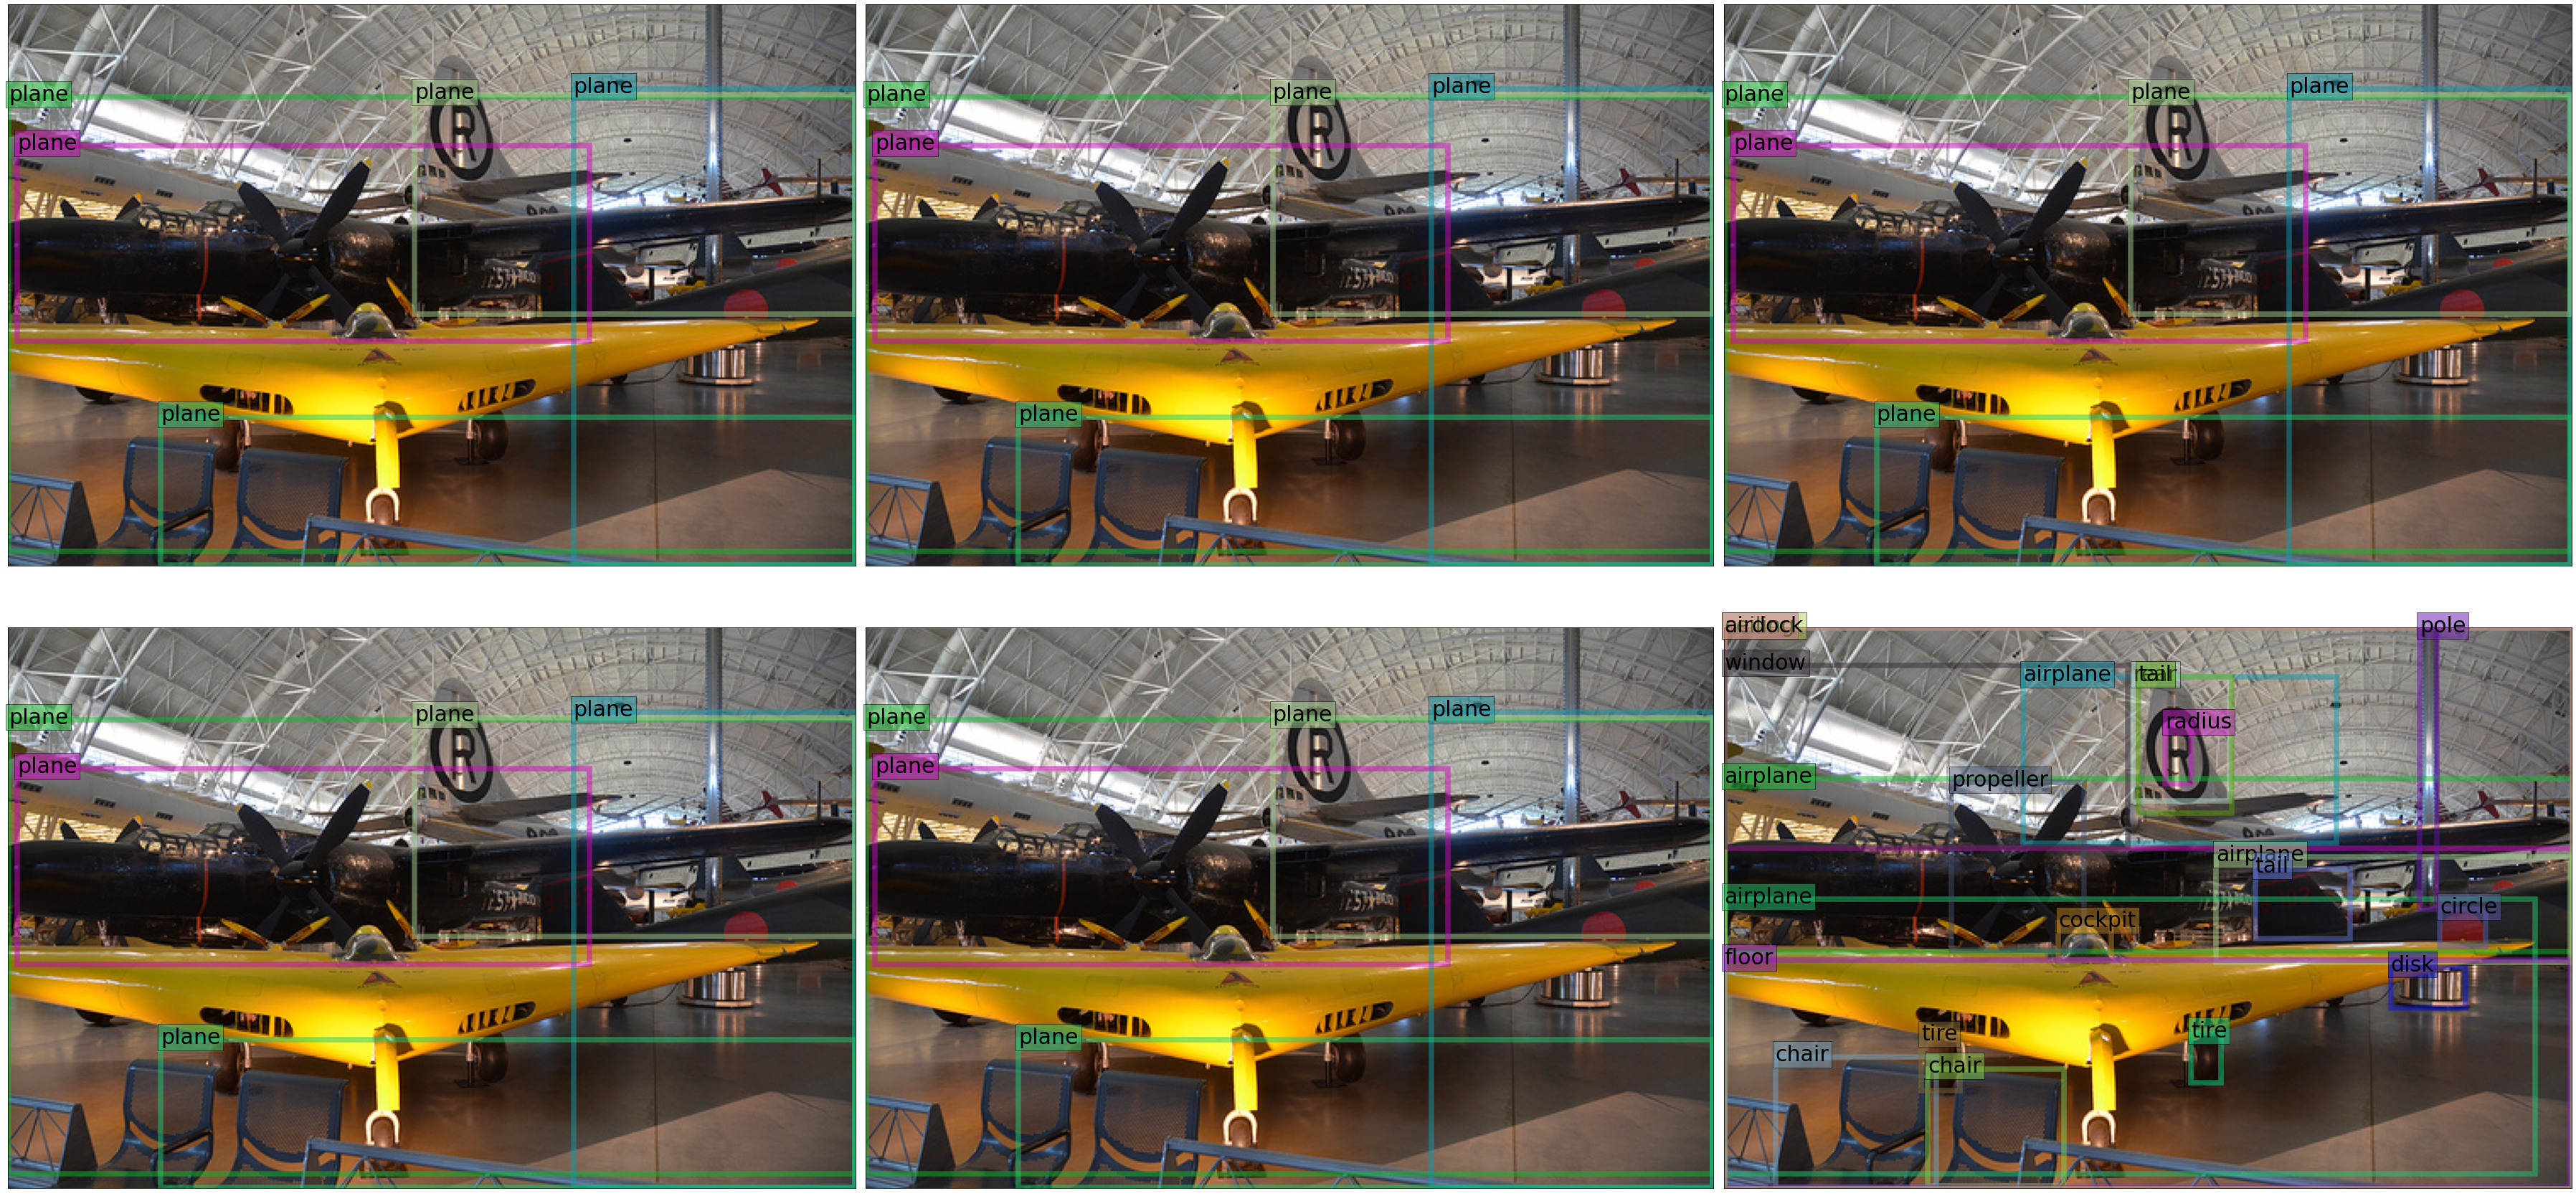

In [266]:
# the images with key rels
pd.set_option('display.max_rows', 50)
i=19
j = list(vgcoco_entity_sets['meta_dbidx']).index(vgcoco_keyrel_sets.iloc[i]['meta_dbidx'])
ifr = validate_keyrel_vis(cap_sgentities[str(vgcoco_keyrel_sets.iloc[i]['meta_vgids'])],cleanse_objects[vgcoco_keyrel_sets.iloc[i]['meta_dbidx']],
                          all_annot_ref_counters[j], infoFromCaps[j].copy(), infoFromRels[j].copy())
ifr

In [259]:
infoFromCaps[j]

nodes  \
0           [man-2, wave-5, surfboard-11]   
1                     [surfer-2, mist-10]   
2                       [board-6, wave-9]   
3  [man-2, surfboard-5, ocean-8, wave-11]   
4                [man-2, wave-6, ocean-9]   

                                                                             edges  \
0                   [[man-2, ride, wave-5], [man-2, ride on top of, surfboard-11]]   
1                                                   [[surfer-2, hang on, mist-10]]   
2                                                        [[board-6, ride, wave-9]]   
3  [[man-2, ride, surfboard-5], [man-2, ride in, ocean-8], [ocean-8, on, wave-11]]   
4                                   [[man-2, surf, wave-6], [wave-6, of, ocean-9]]   

                                          captions  \
0  a man riding a wave on top of a white surfboard   
1      a surfer hanging ten on a wave of aqua mist   
2              a man on a surf board riding a wave   
3  a man riding a surfboard in the ocean on a wave   
4          a man is surfing the waves of the ocean   

                                                                                                bboxes  \
0  [[156.50584411621094, 201.13165283203125, 295.07080078125, 273.93597412109375], [101.61113739013...   
1  [[0.0, 0.0, 499.0, 130.65321350097656], [156.50584411621094, 201.13165283203125, 295.07080078125...   
2  [[174.64747619628906, 95.34626770019531, 342.11553955078125, 257.2763671875], [190.9966735839843...   
3  [[156.50584411621094, 201.13165283203125, 295.07080078125, 273.93597412109375], [101.61113739013...   
4  [[174.64747619628906, 95.34626770019531, 342.11553955078125, 257.2763671875], [190.9966735839843...   

                                                          names  \
0  [surfboard, surfboard, surfboard, man, man, man, wave, wave]   
1            [sky, surfboard, surfboard, surfboard, wave, wave]   
2                                   [man, man, man, wave, wave]   
3  [surfboard, surfboard, surfboard, man, man, man, wave, wave]   
4                                   [man, man, man, wave, wave]   

                                                                       det_seqs  \
0  [man, man, None, wave, wave, None, _, None, surfboard, surfboard, surfboard]   
1          [surfboard, surfboard, None, None, None, wave, wave, None, sky, sky]   
2                                   [man, man, None, _, _, _, None, wave, wave]   
3          [man, man, None, surfboard, surfboard, None, _, _, None, wave, wave]   
4                                [man, man, None, None, wave, wave, None, _, _]   

                                                                noun_chunks  
0  [[a man, man], [a wave, wave], [top, _], [a white surfboard, surfboard]]  
1                 [[a surfer, surfboard], [a wave, wave], [aqua mist, sky]]  
2                         [[a man, man], [a surf board, _], [a wave, wave]]  
3  [[a man, man], [a surfboard, surfboard], [the ocean, _], [a wave, wave]]  
4                         [[a man, man], [the waves, wave], [the ocean, _]]

In [227]:
infoFromObjects[j]

names                     wns  object_ids  \
0     black and white                    None      145371   
1              camera             camera.n.01      145379   
2                 cow                cow.n.01      145370   
3               field              field.n.01     3799007   
4          foreground         foreground.n.01     3799002   
5               grass              grass.n.01      145366   
6               grass              grass.n.01      145367   
7            hayfield           hayfield.n.01     3799001   
8               field              field.n.01      145362   
9    green leafy tree                    None      145368   
10               land               land.n.04     3799006   
11             branch             branch.n.01      145369   
12               leaf               leaf.n.01      145384   
13               name               name.n.01      145380   
14             shadow             shadow.n.01      145378   
15  topographic_point  topographic_point.n.01     3799003   
16                sun                sun.n.01      145396   
17               tree               tree.n.01      145386   
18              grass              grass.n.01      145393   
19              shade              shade.n.01      145395   
20  tree limb hanging                    None      145376   
21           hayfield           hayfield.n.01     3799005   

                  bboxes  
0   [289, 248, 359, 288]  
1   [125, 265, 153, 306]  
2    [81, 260, 124, 294]  
3     [0, 142, 499, 404]  
4   [141, 302, 265, 346]  
5     [0, 323, 496, 400]  
6   [193, 312, 424, 405]  
7   [153, 227, 436, 367]  
8    [78, 235, 479, 320]  
9       [4, 0, 495, 226]  
10  [151, 210, 301, 259]  
11  [320, 153, 376, 227]  
12     [5, 85, 424, 156]  
13  [450, 384, 492, 401]  
14  [107, 211, 498, 255]  
15  [167, 255, 197, 276]  
16   [267, 84, 438, 139]  
17   [226, 92, 259, 228]  
18  [460, 293, 496, 315]  
19  [144, 223, 406, 245]  
20   [265, 96, 466, 226]  
21   [77, 322, 250, 402]